---
title: "Using convnets with small datasets"
output: 
  html_notebook: 
    theme: cerulean
    highlight: textmate
---



***

This notebook contains the code samples found in Chapter 5, Section 2 of [Deep Learning with R](https://www.manning.com/books/deep-learning-with-r). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

***

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can potentially suffice if the model is small and well-regularized and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. You can download the original dataset at: https://www.kaggle.com/c/dogs-vs-cats/data (you will need to create a Kaggle account if you don't already have one -- don't worry, the process is painless).

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our models on less than 10% of the data that was available to the competitors. This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [0]:
# This is a copy of train.zip contained in the original dataset dogs-vs-cats.zip.
# The copy is larger than 500MB. 
# If it takes long time to download it, download trainsmall.zip 
# which cntains just the files you need in this example.
download.file("http://www.sakurai.comp.ae.keio.ac.jp/classes/TopicsML/cats_and_dogs_small.zip", "cats_and_dogs_small.zip")

In [0]:
unzip("cats_and_dogs_small.zip")

In [0]:
# Where are we now?
getwd()

[1] "/content"

In [0]:
system( paste("ls -al ", getwd()), intern=T)

[1] "total 88712"                                                         
[2] "drwxr-xr-x 1 root root     4096 Jan 12 09:41 ."                      
[3] "drwxr-xr-x 1 root root     4096 Jan 12 09:39 .."                     
[4] "drwxr-xr-x 2 root root   135168 Jan 12 09:41 cats_and_dogs_small"    
[5] "-rw-r--r-- 1 root root 90683219 Jan 12 09:41 cats_and_dogs_small.zip"
[6] "drwxr-xr-x 1 root root     4096 Jan  8 16:41 .config"                
[7] "drwxr-xr-x 1 root root     4096 Dec 18 16:52 sample_data"

train/train.zip will be lost when the connection is closed.

In [0]:
original_dataset_dir <- "cats_and_dogs_small"

base_dir <- "./"

train_dir <- file.path(base_dir, "train")
if ( !dir.exists(train_dir) ) dir.create(train_dir)

validation_dir <- file.path(base_dir, "validation")
if ( !dir.exists(validation_dir) ) dir.create(validation_dir)

test_dir <- file.path(base_dir, "test")
if ( !dir.exists(test_dir) ) dir.create(test_dir)

train_cats_dir <- file.path(train_dir, "cats")
if ( !dir.exists(train_cats_dir) ) dir.create(train_cats_dir)

train_dogs_dir <- file.path(train_dir, "dogs")
if ( !dir.exists(train_dogs_dir) ) dir.create(train_dogs_dir)

validation_cats_dir <- file.path(validation_dir, "cats")
if ( !dir.exists(validation_cats_dir) ) dir.create(validation_cats_dir)

validation_dogs_dir <- file.path(validation_dir, "dogs")
if ( !dir.exists(validation_dogs_dir) ) dir.create(validation_dogs_dir)

test_cats_dir <- file.path(test_dir, "cats")
if ( !dir.exists(test_cats_dir) ) dir.create(test_cats_dir)

test_dogs_dir <- file.path(test_dir, "dogs")
if ( !dir.exists(test_dogs_dir) ) dir.create(test_dogs_dir)

fnames <- paste0("cat.", 1:1000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames), 
          file.path(train_cats_dir)) 

fnames <- paste0("cat.", 1001:1500, ".jpg")
file.copy(file.path(original_dataset_dir, fnames), 
          file.path(validation_cats_dir))

fnames <- paste0("cat.", 1501:2000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(test_cats_dir))

fnames <- paste0("dog.", 1:1000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(train_dogs_dir))

fnames <- paste0("dog.", 1001:1500, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(validation_dogs_dir)) 

fnames <- paste0("dog.", 1501:2000, ".jpg")
file.copy(file.path(original_dataset_dir, fnames),
          file.path(test_dogs_dir))

As a sanity check, let's count how many pictures we have in each training split (train/validation/test):

In [0]:
cat("total training cat images:", length(list.files(train_cats_dir)), "\n")

total training cat images: 1000 


In [0]:
cat("total training dog images:", length(list.files(train_dogs_dir)), "\n")

total training dog images: 1000 


In [0]:
cat("total validation cat images:", length(list.files(validation_cats_dir)), "\n")

total validation cat images: 500 


In [0]:
cat("total validation dog images:", length(list.files(validation_dogs_dir)), "\n")

total validation dog images: 500 


In [0]:
cat("total test cat images:", length(list.files(test_cats_dir)), "\n")

total test cat images: 500 


In [0]:
 cat("total test dog images:", length(list.files(test_dogs_dir)), "\n")

total test dog images: 500 


So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate measure of success.

## Building our network

You built a small convnet for MNIST in the previous example, so you should be familiar with convnets. You'll reuse the same general structure: the convnet will be a stack of alternated `layer_conv_2d()` (with `relu` activation) and `layer_max_pooling_2d()` stages.

But because you're dealing with bigger images and a more complex problem, you'll make your network larger, accordingly: it will have one more `layer_conv_2d()` + `layer_max_pooling_2d()` stage. This serves both to augment the capacity of the network and to further reduce the size of the feature maps so they aren't overly large when you reach the `layer_flatten()`. Here, because you start from inputs of size 150 × 150 (a somewhat arbitrary choice), you end up with feature maps of size 7 × 7 just before the `layer_flatten()`.

The depth of the feature maps progressively increases in the network (from 32 to 128), whereas the size of the feature maps decreases (from 148 × 148 to 7 × 7). This is a pattern you'll see in almost all convnets.

Because you're attacking a binary-classification problem, you'll end the network with a single unit (a `layer_dense()` of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [0]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘rappdirs’, ‘config’, ‘reticulate’, ‘tensorflow’, ‘tfruns’




In [0]:
library(keras)

model <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 3)) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_flatten() %>% 
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [0]:
summary(model)

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv2d (Conv2D)                     (None, 148, 148, 32)            896         
________________________________________________________________________________
max_pooling2d (MaxPooling2D)        (None, 74, 74, 32)              0           
________________________________________________________________________________
conv2d_1 (Conv2D)                   (None, 72, 72, 64)              18496       
________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)      (None, 36, 36, 64)              0           
________________________________________________________________________________
conv2d_2 (Conv2D)                   (None, 34, 34, 128)             73856       
________________________________________________________________________________
max_pool

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to use in various situations).

In [0]:
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-4),
  metrics = c("acc")
)

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras includes a number of image processing helper tools. In particular, it includes the `image_data_generator()` function, which can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [0]:
# All images will be rescaled by 1/255
train_datagen <- image_data_generator(rescale = 1/255)
validation_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  # This is the target directory
  train_dir,
  # This is the data generator
  train_datagen,
  # All images will be resized to 150x150
  target_size = c(150, 150),
  batch_size = 20,
  # Since we use binary_crossentropy loss, we need binary labels
  class_mode = "binary"
)

validation_generator <- flow_images_from_directory(
  validation_dir,
  validation_datagen,
  target_size = c(150, 150),
  batch_size = 20,
  class_mode = "binary"
)

Let's look at the output of one of these generators: it yields batches of 150 × 150 RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20)`). There are 20 samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it loops endlessly over the images in the target folder.

In [0]:
batch <- generator_next(train_generator)
str(batch)

List of 2
 $ : num [1:20, 1:150, 1:150, 1:3] 0.3255 0.2353 0.0471 0.1569 0.5804 ...
 $ : num [1:20(1d)] 0 1 1 1 0 1 0 0 1 0 ...


Let's fit the model to the data using the generator. You do so using the `fit_generator` function, the equivalent of `fit` for data generators like this one. It expects as its first argument a generator that will yield batches of inputs and targets indefinitely, like this one does. Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator -- that is, after having run for `steps_per_epoch` gradient descent steps -- the fitting process will go to the next epoch. In this case, batches are 20-samples large, so it will take 100 batches until you see your target of 2,000 samples.

When using `fit_generator`, you can pass a `validation_data` argument, much as with the `fit` function. It's important to note that this argument is allowed to be a data generator, but it could also be a list of arrays. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly; thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [0]:
pb <- callback_progbar_logger(count_mode = "samples", stateful_metrics = NULL)

history <- model %>% fit_generator(
  train_generator,
#  callbacks=c(pb),
  steps_per_epoch = 100,
  epochs = 30,  ## be patient. will take about 5 min. when GPU is utilized.
  validation_data = validation_generator,
  validation_steps = 50
)

It is good practice to always save your models after training:

In [0]:
model %>% save_model_hdf5("cats_and_dogs_small_1.h5")

Let's plot the loss and accuracy of the model over the training and validation data during training:

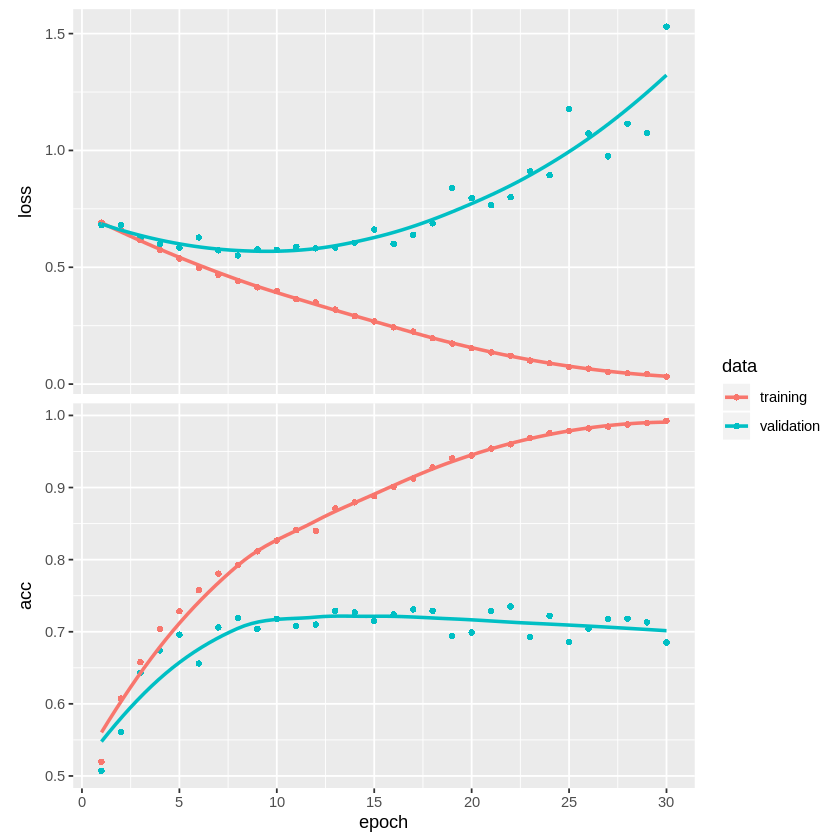

In [0]:
plot(history)

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by an `image_data_generator()`. Let's get started with an example.

In [0]:
datagen <- image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE,
  fill_mode = "nearest"
)

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

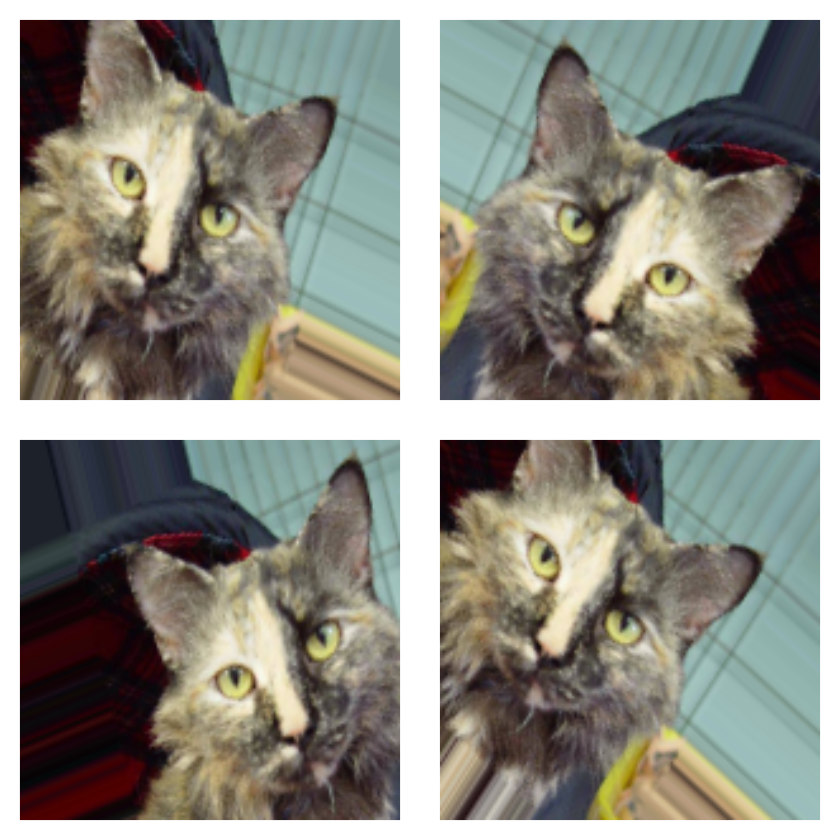

In [0]:
# We pick one image to "augment"
fnames <- list.files(train_cats_dir, full.names = TRUE)
img_path <- fnames[[2]]

# Convert it to an array with shape (150, 150, 3)
img <- image_load(img_path, target_size = c(150, 150))
img_array <- image_to_array(img)
img_array <- array_reshape(img_array, c(1, 150, 150, 3))

# Generated that will flow augmented images
augmentation_generator <- flow_images_from_data(
  img_array, 
  generator = datagen, 
  batch_size = 1 
)

# Plot the first 4 augmented images
op <- par(mfrow = c(2, 2), pty = "s", mar = c(1, 0, 1, 0))
for (i in 1:4) {
  batch <- generator_next(augmentation_generator)
  plot(as.raster(batch[1,,,]))
}
par(op)

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a dropout layer to our model, right before the densely-connected classifier:

In [0]:
model <- keras_model_sequential() %>% 
  layer_conv_2d(filters = 32, kernel_size = c(3, 3), activation = "relu",
                input_shape = c(150, 150, 3)) %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 64, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_conv_2d(filters = 128, kernel_size = c(3, 3), activation = "relu") %>% 
  layer_max_pooling_2d(pool_size = c(2, 2)) %>% 
  layer_flatten() %>% 
  layer_dropout(rate = 0.5) %>% 
  layer_dense(units = 512, activation = "relu") %>% 
  layer_dense(units = 1, activation = "sigmoid")  
  
model %>% compile(
  loss = "binary_crossentropy",
  optimizer = optimizer_rmsprop(lr = 1e-4),
  metrics = c("acc")
)

Let's train our network using data augmentation and dropout:

In [0]:
datagen <- image_data_generator(
  rescale = 1/255,
  rotation_range = 40,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2,
  horizontal_flip = TRUE
)

test_datagen <- image_data_generator(rescale = 1/255)

train_generator <- flow_images_from_directory(
  train_dir,
  datagen,
  target_size = c(150, 150),
  batch_size = 32,
  class_mode = "binary"
)

validation_generator <- flow_images_from_directory(
  validation_dir,
  test_datagen,
  target_size = c(150, 150),
  batch_size = 32,
  class_mode = "binary"
)

#pb <- callback_progbar_logger(count_mode = "samples", stateful_metrics = NULL)
format(Sys.time(), "%a %b %d %X %Y %Z") 

history <- model %>% fit_generator(
  train_generator,
#  callbacks=c(pb),  ## callback does not work in ipynb
  steps_per_epoch = 100,
  epochs = 100,   ## 100 in the book   # it takes 25s to 30s with GPU 
  validation_data = validation_generator,
  validation_steps = 50
)

format(Sys.time(), "%a %b %d %X %Y %Z") 

[1] "Sun Jan 12 09:58:35 AM 2020 UTC"

[1] "Sun Jan 12 10:41:35 AM 2020 UTC"

Let's save our model -- we will be using it in the section on convnet visualization.

In [0]:
model %>% save_model_hdf5("cats_and_dogs_small_2.h5")

Let's plot our results again:

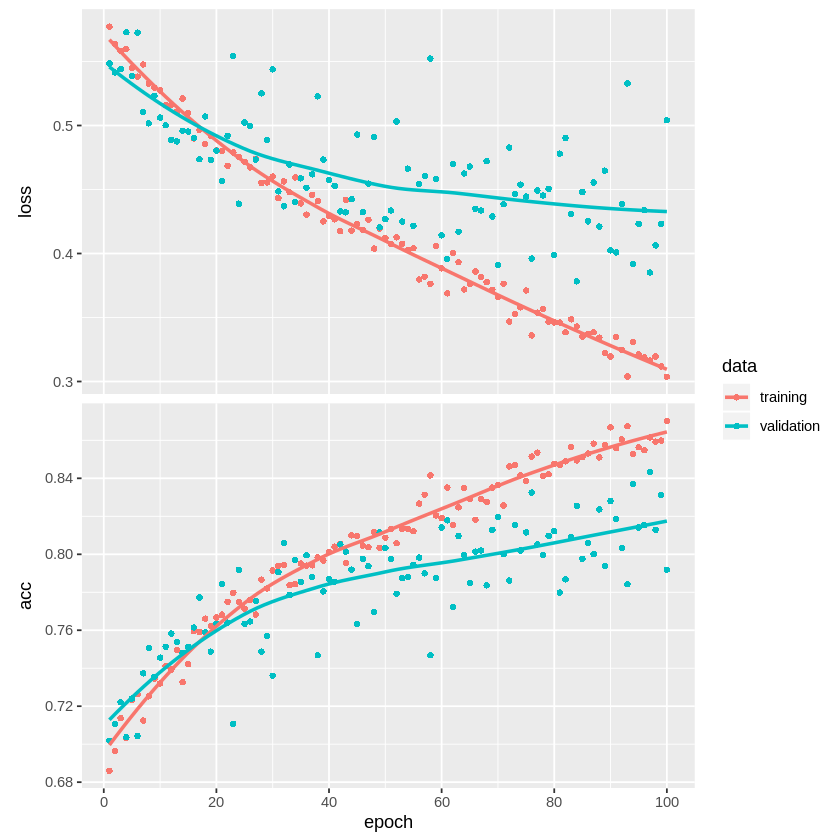

In [0]:
plot(history)

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two sections.